<h1 align=center>Time Series Analysis</h1>

#### Time Series Components:

- Trend: Long-term movement in data (upward, downward, or stable)
- Seasonality: Regular patterns that repeat over known periods (daily, weekly, yearly)
- Cyclical patterns: Irregular fluctuations that don't have fixed periods
- Noise/Random variation: Unpredictable fluctuations

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [92]:
df = pd.read_csv('AirPassengers.csv', parse_dates=[0], index_col=[0])
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [93]:
df = df.rename(columns={'#Passengers': 'passengers'})
df.head()

,passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


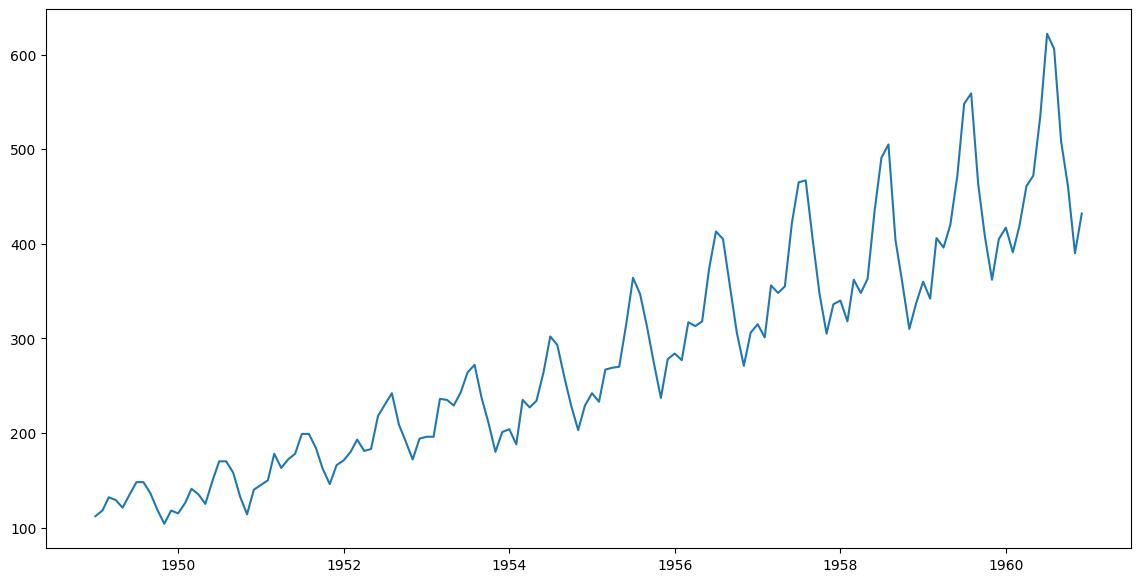

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(df)
plt.show()

### 1. Using Neural Network

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import RootMeanSquaredError

In [ ]:
# split the data into training and testing sets
train_size = int(len(df) * 0.8)
train = df[:train_size]
test = df[train_size:]

# define the number of lagged time steps to use as input features
n_lags = 12
# n_lags = 12 defines how many previous time steps
# we'll use to predict the next value. Here we use 12 months of historical data.

# create the input and output data for the neural network
X_train = np.array([train["passengers"].values[i:i+n_lags] for i in range(len(train)-n_lags)])
y_train = np.array(train["passengers"].values[n_lags:])
X_test = np.array([test["passengers"].values[i:i+n_lags] for i in range(len(test)-n_lags)])
y_test = np.array(test["passengers"].values[n_lags:])

In [ ]:
# create the neural network model
model = Sequential()
model.add(Dense(10, input_dim=n_lags, activation="relu"))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam", metrics=[RootMeanSquaredError()])

# train the neural network model
model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)

In [ ]:
# make predictions on the testing set using the trained model
predictions = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


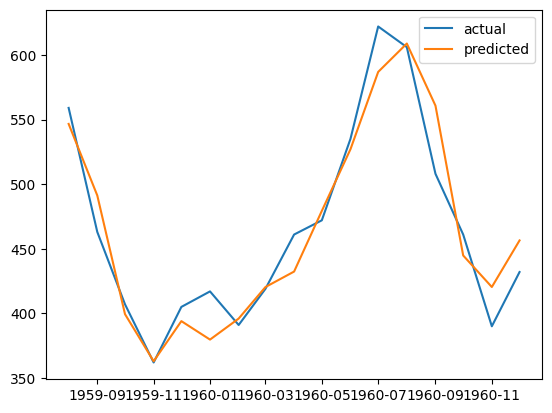

In [ ]:
# plot the actual and predicted values
plt.plot(test.index[-len(predictions):], test["passengers"].values[-len(predictions):], label="actual")
plt.plot(test.index[-len(predictions):], predictions, label="predicted")
plt.legend()
plt.show()

### 2. LSTM

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
def check_stationarity(timeseries):
    """
    Purpose: This function checks the stationarity of the time series.
    It calculates and plots the rolling mean and standard deviation to visualize any trends or seasonality.
    The Dickey-Fuller test is performed to statistically determine if the series is stationary.
    """

    # Calculate rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()

    # Plot rolling statistics
    plt.figure(figsize=(10, 6))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    # Perform Dickey-Fuller test
    print('Dickey-Fuller Test Results:')
    df_test = adfuller(timeseries)
    df_output = pd.Series(df_test[:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in df_test[4].items():
        df_output[f'Critical Value ({key})'] = value
    print(df_output)

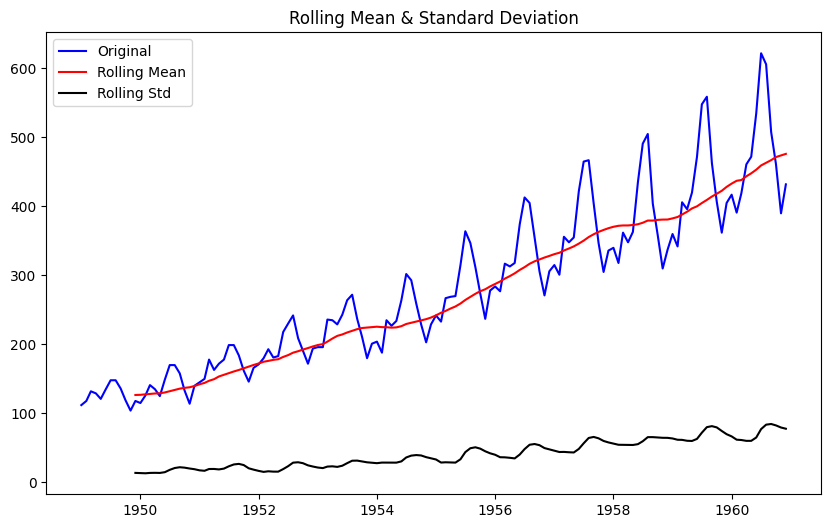

Dickey-Fuller Test Results:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [ ]:
check_stationarity(df)

In [ ]:
# lets create a date column with a monthly end frequency starting from January 1949.
# This enables time-based indexing for the DataFrame, essential for time series analysis.
df['Date'] = pd.date_range(start='1949-01-01', periods=len(df), freq='ME')

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objs as go

In [ ]:
decomposition_result = seasonal_decompose(df["passengers"], model="additive", period=12)

fig = make_subplots(rows=4, cols=1, subplot_titles=("Original Series", "Trend Component", "Seasonal Component", "Residuals"))

fig.add_trace(go.Scatter(x=df["Date"], y=decomposition_result.observed, mode="lines", name="Original", line=dict(color="darkblue")), row=1, col=1)
fig.add_trace(go.Scatter(x=df["Date"], y=decomposition_result.trend, mode="lines", name="Trend", line=dict(color="green")), row=2, col=1)
fig.add_trace(go.Scatter(x=df["Date"], y=decomposition_result.seasonal, mode="lines", name="Seasonality", line=dict(color="purple")), row=3, col=1)
fig.add_trace(go.Scatter(x=df["Date"], y=decomposition_result.resid, mode="lines", name="Residuals", line=dict(color="orange")), row=4, col=1)

fig.update_layout(title="Decomposition of Time Series", height=900, showlegend=False, plot_bgcolor="whitesmoke")

animation_frames = []
for i in range(len(df)):
    frame = go.Frame(data=[go.Scatter(x=df["Date"][:i+1], y=decomposition_result.observed[:i+1], mode="lines", name="Original", line=dict(color="darkblue")),
                            go.Scatter(x=df["Date"][:i+1], y=decomposition_result.trend[:i+1], mode="lines", name="Trend", line=dict(color="green")),
                            go.Scatter(x=df["Date"][:i+1], y=decomposition_result.seasonal[:i+1], mode="lines", name="Seasonality", line=dict(color="purple")),
                            go.Scatter(x=df["Date"][:i+1], y=decomposition_result.resid[:i+1], mode="lines", name="Residuals", line=dict(color="orange"))],
                      traces=[0, 1, 2, 3])
    animation_frames.append(frame)

fig.frames = animation_frames

fig.update_layout(updatemenus=[dict(type="buttons", showactive=False,
                                    buttons=[dict(label="Play", method="animate", args=[None, {"frame": {"duration": 400, "redraw": True}, "fromcurrent": True, "mode": "immediate"}]),
                                             dict(label="Pause", method="animate", args=[[None], {"frame": {"duration": 0, "redraw": False}, "mode": "immediate"}])])])

fig.show()

`Note:` The code above is written to facilitate the understanding and visualization of components in time series analysis. By observing the time series, trends, seasonality, and residuals, we can better comprehend the dynamics of the data. The animation allows these changes to be presented in a more interactive and comprehensible manner.

In [ ]:
df_log = np.log(df["passengers"])

df_log_diff = df_log - df_log.shift()

# This will apply a logarithmic transformation to the passengers' data to stabilize the variance and reduce the impact of extreme values (outliers).

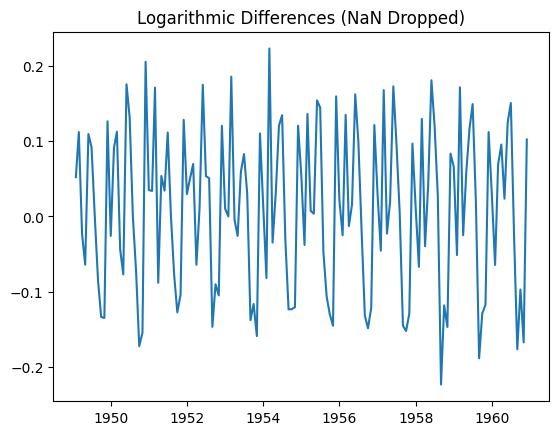

In [ ]:
plt.plot(df_log_diff.dropna())
plt.title("Logarithmic Differences (NaN Dropped)")
plt.show()

#This visualization displays the log differences, allowing us to observe the changes in the series over time and assess whether it appears stationary after differencing.

In [ ]:
df_log_diff = df_log_diff.dropna()

In [ ]:
df.head()

,passengers,Date
Month,,
1949-01-01,112,1949-01-31
1949-02-01,118,1949-02-28
1949-03-01,132,1949-03-31
1949-04-01,129,1949-04-30
1949-05-01,121,1949-05-31


In [ ]:
df = df.drop(columns=['Date'])
df.head()

,passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [94]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df = scaler.fit_transform(df)

In [95]:
df[:3]

array([[0.01544402],
       [0.02702703],
       [0.05405405]])

In [96]:
train = df[0:100,:]
test = df [100:,:]

In [97]:
def get_data(df, steps):
    """
    data: A 2D NumPy array, usually with shape (n_samples, 1) or more columns.
    steps: The number of past time steps used as features (input sequence length).
    """
    dataX = []
    dataY = []
    for i in range(len(df)-steps-1):
        a = df[i:(i+steps), 0]
        dataX.append(a)
        dataY.append(df[i+steps, 0])
    return np.array(dataX), np.array(dataY)

# This function is written to prepare the training set.

```
 get_data(data, steps=3) will generate:
Input Sequence (X)	Target Value (Y)
[10, 11, 12]	      13
[11, 12, 13]	      14
[12, 13, 14]	      15
[13, 14, 15]	      16
```

In [98]:
X_train, y_train = get_data(train, steps=3)
X_test, y_test = get_data(test, steps=3)

Summary

`Model Type` `Use get_data?`	 `Reshape Needed?`	`Input Shape`
- LSTM / GRU / RNN:	✅ Yes: ✅ Yes → 3D:	(samples, steps, 1)
- MLP / Dense NN:	✅ Yes:	❌ No:	(samples, steps)
- Random Forest / XGB:	✅ Yes:	❌ No:	(samples, steps)
- ARIMA / Prophet:	❌ No:	❌ No:	Raw time series



In [99]:
# X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

In [100]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [101]:
LSTMmodel = Sequential()
LSTMmodel.add(Input(shape=(1, steps)))

LSTMmodel.add(LSTM(128, return_sequences=True))
LSTMmodel.add(Dropout(0.2))

LSTMmodel.add(LSTM(64))
LSTMmodel.add(Dropout(0.2))

LSTMmodel.add(Dense(32, activation="relu"))
LSTMmodel.add(Dense(1))

LSTMmodel.compile(loss='mean_squared_error', optimizer='adam')

In [102]:
LSTMmodel.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 1, 128)         │        67,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 119,105 (465.25 KB)

 Trainable params: 119,105 (465.25 KB)

 Non-trainable params: 0 (0.00 B)

In [103]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)

LSTMmodel.fit(X_train, y_train,
          epochs=100,
          batch_size=16,
          validation_split=0.1,
          callbacks=[early_stop, reduce_lr],
          verbose=1)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 534ms/step - loss: 0.0520 - val_loss: 0.1728 - learning_rate: 0.0010
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0362 - val_loss: 0.1270 - learning_rate: 0.0010
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0209 - val_loss: 0.0795 - learning_rate: 0.0010
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - loss: 0.0124 - val_loss: 0.0391 - learning_rate: 0.0010
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0098 - val_loss: 0.0226 - learning_rate: 0.0010
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0112 - val_loss: 0.0249 - learning_rate: 0.0010
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0086 - val_loss: 0.0324 - learning_rate: 0.0010
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0060 - val_loss: 0.0344 - learning_rate: 0.0010
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0074 - val_loss: 0.0262 - learning_rate: 0.0010
Epoch 10/100
6/6 ━━━━━━━━

In [104]:
y_pred = LSTMmodel.predict(X_test)


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


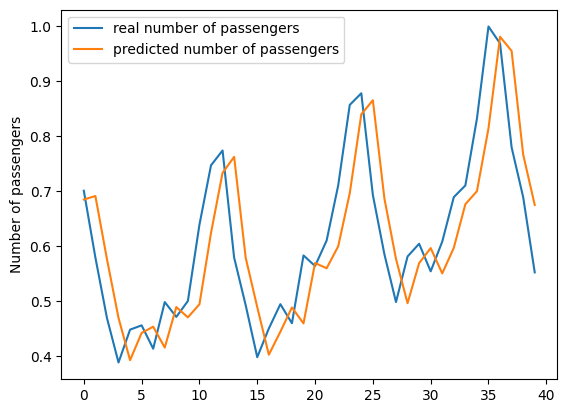

In [105]:
plt.plot(y_test, label = 'real number of passengers')
plt.plot(y_pred, label = 'predicted number of passengers')
plt.ylabel('Months')
plt.ylabel('Number of passengers')
plt.legend()
plt.show()

In [106]:
def plot_prediction(y_true, y_pred, sample_size=100):
    sample_size = min(len(y_true), sample_size)

    indices = np.random.choice(range(len(y_true)), size=sample_size, replace=False)
    y_true_sample = y_true[indices]
    y_pred_sample = y_pred[indices]

    plt.figure(figsize=(10, 6))

    plt.plot(y_true_sample, label="Actual Values", marker='o', color='b')

    plt.plot(y_pred_sample, label="Predicted Values", marker='x', color='r')

    plt.title("Comparison of True and Predicted Values")
    plt.xlabel("Samples")
    plt.ylabel("Values")
    plt.legend()
    plt.grid(True)
    plt.show()

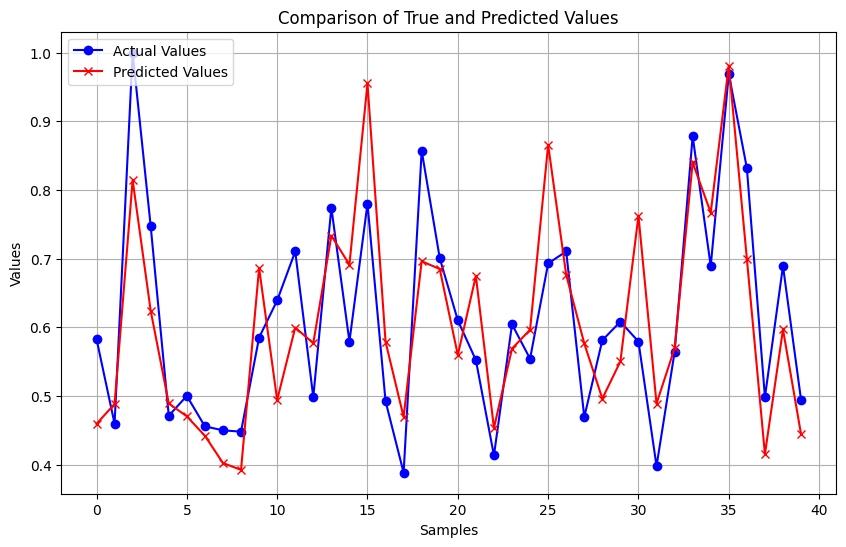

In [107]:
plot_prediction(y_test, y_pred)

### Random forest

In [115]:
df = pd.read_csv('AirPassengers.csv', parse_dates=[0], index_col=[0])
df = df.rename(columns={'#Passengers': 'passengers'})
df.head()

,passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [111]:
def f_data(data, steps):
    datax = []
    datay = []
    for i in range(len(data) - steps - 1):
        a = data[i:(i + steps), 0]
        datax.append(a)
        datay.append(data[i + steps, 0])
    return np.array(datax), np.array(datay)

In [117]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df = scaler.fit_transform(df)

In [118]:
train = df[0:100,:]
test = df [100:,:]

In [119]:
X_train, y_train = f_data(train, steps=3)
X_test, y_test = f_data(test, steps=3)

# No reshape needed — Random Forest works with 2D

In [120]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


# Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse:.2f}")


Test MSE: 0.03


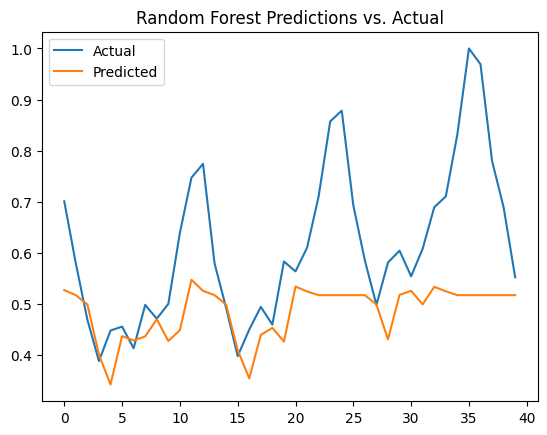

In [121]:
import matplotlib.pyplot as plt

plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.title('Random Forest Predictions vs. Actual')
plt.show()


In [122]:
y_train

array([0.04826255, 0.03281853, 0.05984556, 0.08494208, 0.08494208,
       0.06177606, 0.02895753, 0.        , 0.02702703, 0.02123552,
       0.04247104, 0.07142857, 0.05984556, 0.04054054, 0.08687259,
       0.12741313, 0.12741313, 0.1042471 , 0.05598456, 0.01930502,
       0.06949807, 0.07915058, 0.08880309, 0.14285714, 0.11389961,
       0.13127413, 0.14285714, 0.18339768, 0.18339768, 0.15444015,
       0.11196911, 0.08108108, 0.11969112, 0.12934363, 0.14671815,
       0.17181467, 0.14864865, 0.15250965, 0.22007722, 0.24324324,
       0.26640927, 0.2027027 , 0.16795367, 0.13127413, 0.17374517,
       0.17760618, 0.17760618, 0.25482625, 0.25289575, 0.24131274,
       0.26833977, 0.30888031, 0.32432432, 0.25675676, 0.20656371,
       0.14671815, 0.18725869, 0.19305019, 0.16216216, 0.25289575,
       0.23745174, 0.25096525, 0.30888031, 0.38223938, 0.36486486,
       0.2992278 , 0.24131274, 0.19111969, 0.24131274, 0.26640927,
       0.24903475, 0.31467181, 0.31853282, 0.32046332, 0.40733